# 4096 Channel 2/1 Oversampled 4 GHz Polyphase Filterbank on the Xilinx RFSoC

This notebook tests the functionality of the OPFB.

## Imports, Definitions, and Intialize Variables

In [1]:
from mkidgen3.mkidpynq import dma_status
from mkidgen3.testutils import extract_opfb_spec, do_fft
from mkidgen3.fixedpoint import *
import numpy as np
import time
import pynq
from pynq import PL, Overlay, DefaultIP, allocate
from fpbinary import FpBinary, OverflowEnum, RoundingEnum
import matplotlib.pyplot as plt

n_res = 2048 # number of MKID resonators
n_bin = 4096 # number of PFB channels

# initialize vars for data transfer
n_packets_rcvd, n_packets_sent, pptx, input_buffer = 0, 0, None, None
next_sample_send=0

### Load the overlay and extract the dma core

In [2]:
ol = Overlay('exact_old_version.bit')
ol.download()
dma = ol.axi_dma_0
print(f"PL Bitfile: {PL.bitfile_name}\nPL Timestamp: {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")
dma_status(dma)

PL Bitfile: /home/xilinx/jupyter_notebooks/OPFB_Debug/exact_old_version.bit
PL Timestamp: 2022/4/14 22:38:7 +512392
Overlay timestamp: 2022/4/14 22:38:7 +512392  Loaded: True
DMA:
 Buffer Length: 262143 bytes
 MM2s
 Idle:False
 MM2S_DMASR (status):0x0
 MM2S_SA (ptr) :0x0
 MM2S_LENGTH (len):0
 S2MM
 Idle:False
 S2MM_DMASR (status):0x0
 S2MM_DA (ptr) :0x0
 S2MM_LENGTH (len):0


### Data Generation

In [3]:
n_total_packets=272   #How many packets (each packet is enough samples for a single 4096 FFT frame)
n_samples=256*n_total_packets*8  #How many waveform samples do we need to generate
sample_rate=4.096e9

freq=np.array([300.5,302])*1e6 #(np.linspace(1,4094,2046)-2047)*1e6  # -2048-2047 MHz
amplitudes = (np.ones_like(freq))/2
phases= np.zeros_like(freq)

In [4]:
# Generate Comppplex Waveform
t = 2 * np.pi * np.arange(n_samples)/sample_rate
comb=np.zeros(n_samples, dtype=np.complex64)
for i in range(freq.size):
    comb += amplitudes[i] * np.exp(1j * (t * freq[i] + phases[i]))

In [5]:
comb=comb.reshape(comb.size//n_res, n_res)
print(f"Comb shape: {comb.shape}. \nTotal Samples: {comb.size}. Memory: {comb.size*8/1024**2:.0f} MB\n"
      f"Max value: {np.abs(comb).max()}.\n"
      f"Expected tone amplitude factor: ~512 * N_TONES_IN_BIN. (4096/8 as FFT scale dfaults to 8 in last 3 stages)\n"
      f"Resulting samples per output bin: {comb.size*2/n_bin}")

Comb shape: (272, 2048). 
Total Samples: 557056. Memory: 4 MB
Max value: 1.0.
Expected tone amplitude factor: ~512 * N_TONES_IN_BIN. (4096/8 as FFT scale dfaults to 8 in last 3 stages)
Resulting samples per output bin: 272.0


### Plot an FFT of the first full timeseries to be input to the OPFB

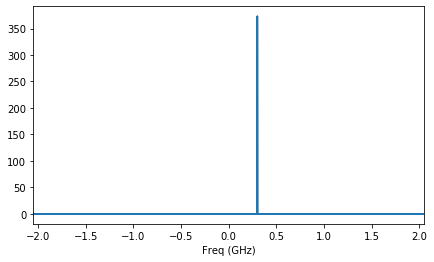

In [6]:
plt.figure(figsize=(7,4))
plt.plot(np.fft.fftfreq(comb.size, d=1/sample_rate)/1e9, 
         np.abs(np.fft.fft(comb.ravel(), norm='ortho')))
plt.xlim(-sample_rate/2e9,sample_rate/2e9);
plt.xlabel('Freq (GHz)');

## Prepare an output array

In [7]:
packets_out=np.zeros((comb.shape[0], n_bin), dtype=np.complex64)

### DMA Transfer Functions

In [8]:
def packet_to_buffer(packet, zero_i=tuple(), zero_q=tuple(), fp=True, fpgen=FP16_15, scale=1,
                     opfb_format=True):
    """
    Converts a packet of complex data into a n_res*2 uint16 array
    Packet should be an array of dtype=np.complex64 or 128. length must be a multiple of 16
    zero_i & zero_q may be set to a tuple to selectively zero out values going into specific lanes
    Setting fp = False will result in the real and imaginaty values being multiplied by scale
    and then cast to uint16. Otherwise FpBinary will be used to convert the data from float to signed 16_15.
    """
    if fp:
        ibits = [fpgen(x).__index__() for x in packet.real]
        qbits = [fpgen(x).__index__() for x in packet.imag]
    else:
        ibits = (packet.real * scale).astype(np.uint16)
        qbits = (packet.imag * scale).astype(np.uint16)
    data = np.zeros(2 * packet.size, dtype=np.uint16)
    if opfb_format:
        for i in range(8):
            data[i::16] = 0 if i in zero_i else ibits[i::8]
            data[i + 8::16] = 0 if i in zero_q else qbits[i::8]
    else:
        data[::2] = ibits
        data[1::2] = qbits
    return data

def prep_buffers(ntx=16, n_res=2048, n_bin=4096, latency_shift=3*16, bin_out=True):
    """
    ntx: How many packets do we send per DMA transfer.
         Must be <=16 to move the stream smoothly through the core
    """
    global pptx, input_buffer, output_buffer
    pptx = ntx

    try:
        # Close buffers if they are open
        input_buffer.close()
        output_buffer.close()
    except (NameError,AttributeError):
        pass

    # Create the buffers
    n_in_buff = n_res * 2 * pptx if n_packets_sent else n_res * 2 * pptx + latency_shift * 2
    input_buffer = allocate(shape=(n_in_buff,), dtype=np.uint16)  # 2048 I & Q
    output_buffer = allocate(shape=((n_bin if bin_out else n_res) * 2,), dtype=np.uint16)
    
def txcomb(dma, comb, n_res=2048, latency_shift=3*16, wait=True, **kwargs):
    global n_packets_sent, pptx, input_buffer, next_sample_send
    # 92/2 empirically determined to overcome reorder core latency

    if n_packets_sent or latency_shift == 0:
        n_to_send = pptx * n_res
        data = comb.ravel()[next_sample_send:next_sample_send + n_to_send]
        input_buffer[:] = packet_to_buffer(data, **kwargs)
    else:
        n_to_send = (pptx - 1) * n_res + latency_shift
        data = comb.ravel()[:n_to_send]
        input_buffer[:n_res * 2] = 0
        input_buffer[n_res * 2:] = packet_to_buffer(data, **kwargs)
    dma.sendchannel.transfer(input_buffer)
    if wait:
        dma.sendchannel.wait()
    next_sample_send += n_to_send
    n_packets_sent = 1 + next_sample_send // n_res
    
def rxpackets(dma, packets_out, n=None, status=False, packet_latency=1, wait=True, **kwargs):
    """Attempts to receive packets. If no number is specified then n_outstanding-1 are received."""
    global n_packets_sent, n_packets_rcvd
    converted=None
    if n is None:
        n = n_packets_sent - n_packets_rcvd - packet_latency
    for i in range(n):
        if status:
            print(f"Receiving packet {n_packets_rcvd}")
        dma.recvchannel.transfer(output_buffer)
        if wait:
            dma.recvchannel.wait()
        converted = packet_from_buffer(output_buffer, **kwargs)
        packets_out[n_packets_rcvd] = converted
        n_packets_rcvd += 1
    return converted

def packet_from_buffer(buffer, fp=True, scale=1, fpformat=(1,15)):
    """
    Converts a buffer of uint16 fixed point data to a np.complex128.
    Buffer must be in multiples of 2*n_bin.
    """
    ibits = np.zeros(buffer.size // 2, dtype=np.uint16)
    qbits = np.zeros(buffer.size // 2, dtype=np.uint16)
    for i in range(16):  # NB this code WILL work for output that is in groups of 8 (resonators) as well
        ibits[i::16] = buffer[2 * i::32]
        qbits[i::16] = buffer[2 * i + 1::32]

    packet = np.zeros(buffer.size // 2, dtype=np.complex128)
    if fp:
        fp = lambda x: FpBinary(int_bits=fpformat[0], frac_bits=fpformat[1], signed=True, bit_field=int(x))
        packet.real = [float(fp(x)) for x in ibits]
        packet.imag = [float(fp(x)) for x in qbits]
    else:
        packet.real = ibits * scale
        packet.imag = qbits * scale

    return packet

def txrx(dma, comb, nper, packets_out, n_total_packets=None, packet_latency=1, in_per_out=2, bin_out=False,
         txfp=FP16_15, rxfp=(1,15), wait=True, show=False, tx_post_opfb=False, latency_shift=3*16):
    if n_total_packets is None:
        n_total_packets=comb.size//256//8
    prep_buffers(nper, bin_out=bin_out, latency_shift=latency_shift)
    n_loop=(n_total_packets - n_packets_sent) // pptx
    for i in range(n_loop):
        txcomb(dma, comb, wait=wait, fpgen=txfp, latency_shift=latency_shift, opfb_format=not tx_post_opfb)
        pending = n_packets_sent//in_per_out - n_packets_rcvd - packet_latency
        if show:
            print(f"Sent: {n_packets_sent}  Pending: {pending}")
        rxpackets(dma, packets_out, n=pending, wait=wait, fpformat=rxfp)
        if show:
            print(f"Received: {n_packets_rcvd}.")
        if i == 0:
            prep_buffers(nper, bin_out=bin_out, latency_shift=latency_shift)

## Send the data

In [9]:
txrx(dma, comb, 4, packets_out, n_total_packets=272, packet_latency=1, in_per_out=1, bin_out=True,
         txfp=FP16_15, rxfp=(1,15), wait=True, show=True, tx_post_opfb=False, latency_shift=3*16)

Sent: 4  Pending: 3
Received: 3.
Sent: 8  Pending: 4
Received: 7.
Sent: 12  Pending: 4
Received: 11.
Sent: 16  Pending: 4
Received: 15.
Sent: 20  Pending: 4
Received: 19.
Sent: 24  Pending: 4
Received: 23.
Sent: 28  Pending: 4
Received: 27.
Sent: 32  Pending: 4
Received: 31.
Sent: 36  Pending: 4
Received: 35.
Sent: 40  Pending: 4
Received: 39.
Sent: 44  Pending: 4
Received: 43.
Sent: 48  Pending: 4
Received: 47.
Sent: 52  Pending: 4
Received: 51.
Sent: 56  Pending: 4
Received: 55.
Sent: 60  Pending: 4
Received: 59.
Sent: 64  Pending: 4
Received: 63.
Sent: 68  Pending: 4
Received: 67.
Sent: 72  Pending: 4
Received: 71.
Sent: 76  Pending: 4
Received: 75.
Sent: 80  Pending: 4
Received: 79.
Sent: 84  Pending: 4
Received: 83.
Sent: 88  Pending: 4
Received: 87.
Sent: 92  Pending: 4
Received: 91.
Sent: 96  Pending: 4
Received: 95.
Sent: 100  Pending: 4
Received: 99.
Sent: 104  Pending: 4
Received: 103.
Sent: 108  Pending: 4
Received: 107.
Sent: 112  Pending: 4
Received: 111.
Sent: 116  Pendin

In [10]:
#Optionally save the data to the FPGA
#if True:
#    np.savez(f"packets_out.npz", freq=freq, phases=phases, amplitudes=amplitudes, packets_out=packets_out)

## Look at the results

In [11]:
packets_out=np.flip(packets_out, axis=0)

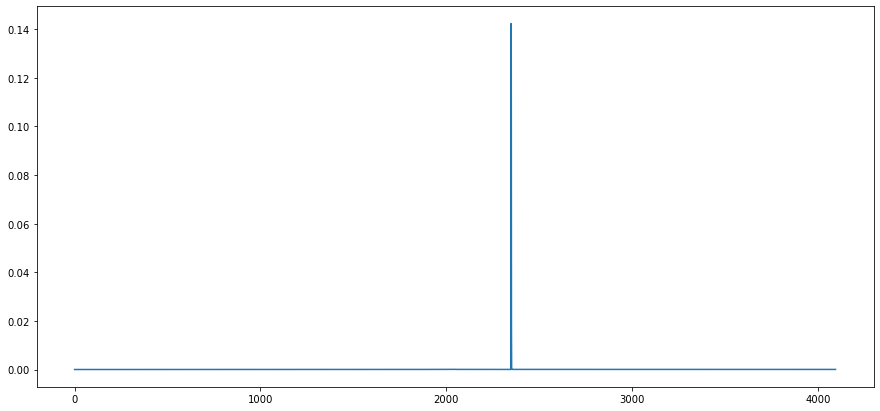

In [12]:
# plot an individual packet
packet_num = 17
plt.figure(figsize=(15,7))
packet = np.fft.fftshift(np.abs(packets_out[packet_num]))
plt.plot(packet)

## Plot the OPFB Spectra

Note pltslc picks out certain FFT frames. We start at 16 with the FPGA data because the first few frames are zeros as the core winds up (check individual packets above). To properly visualize the oversampled spectrum we take the fft of the output time series from each bin. This shows us the frequency content of each bin with spectral resolution 2 MHz/n_packets_received. We stitch the resulting 4096 spectra together, discarding the overlap region, to produce the final, fine spectrum. Not the observed frequency at 0 Hz is the DC offset. This can be mitigated by implementing symmetric rounding to zero at the cost of FPGA resources.

/home/xilinx/src/mkidgen3/mkidgen3/testutils.py:256: RuntimeWarning: divide by zero encountered in log10
  data = np.abs(data) if linear else 20 * np.log10(np.abs(data))


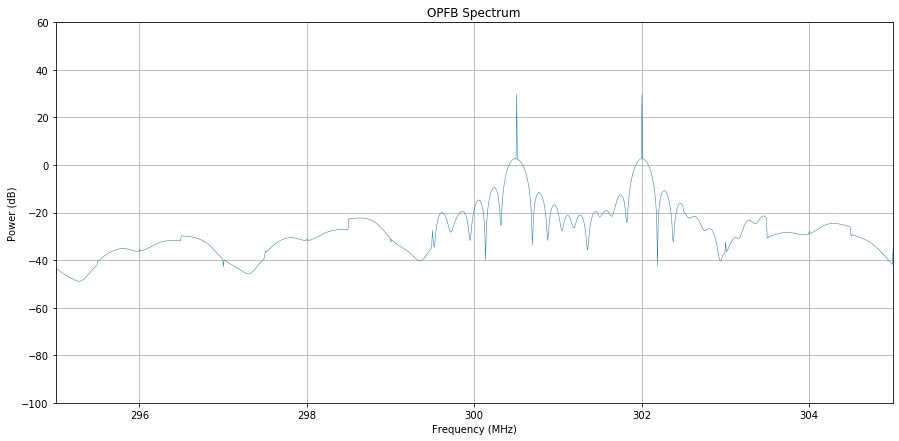

In [13]:
pltslc=slice(16,272)
fpgaplotdata = extract_opfb_spec(do_fft(packets_out, sl=pltslc))
plt.figure(figsize=(15,7))
plt.plot(*fpgaplotdata, label='fpga', linewidth=.5)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dB)')
plt.ylim([-100,60])
plt.xlim([295,305])
plt.grid()
plt.title('OPFB Spectrum')
plt.show()